<a href="https://colab.research.google.com/github/geun-hyoung/python_object_detection_ocr/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

In [1]:
!pip install pytesseract
!pip install opencv-python
!pip install ultralytics

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-kor is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [2]:
import os
os.environ['TESSDATA_PREFIX'] = '/usr/share/tesseract-ocr/4.00/tessdata'

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
plt.style.use('dark_background')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Image Preprocessing

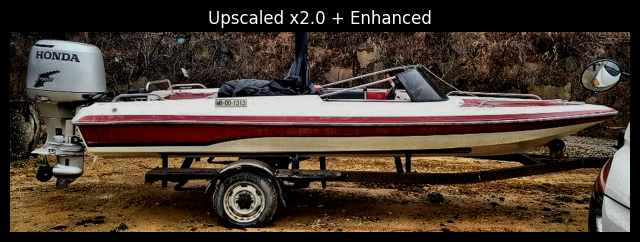

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ============== 설정 ==============
IMG_PATH = '/content/drive/MyDrive/Colab Notebooks/17.jpg'  # 경로에 맞게 수정
MODEL_WEIGHTS = 'yolov8s-seg.pt'
UPSCALE_FACTOR = 2.0
# Enhancement tunables (조정해가며 테스트)
CLAHE_CLIP = 2.0           # CLAHE 강도 (1.0~3.0 권장)
CLAHE_TILE = (8,8)         # CLAHE 타일 크기
BILATERAL_D = 5            # bilateral 필터 직경 (작게 유지)
BILATERAL_SIGMA_COLOR = 15 # bilateral 색상 시그마 (작게: 획 보존)
BILATERAL_SIGMA_SPACE = 50 # bilateral 거리 시그마
SHARP_ALPHA = 0.8          # 언샤프 강도 (0 = 없음, 0.3~0.8 권장)
GAUSS_SIGMA = 1.0          # 언샤프용 가우시안 시그마
GAMMA = 0.8               # 감마 (>1 밝게, <1 어둡게)
BRIGHTNESS = -50         # 밝기 보정 (정수, 음수 가능)
CONTRAST_ALPHA = 1.1       # 전역 대비 스케일 (1.0 = 유지)
# ===================================

# 1) 이미지 로드
img_ori = cv2.imread(IMG_PATH)
if img_ori is None:
    raise FileNotFoundError(f"Image not found: {IMG_PATH}")

# 2) 업스케일 (해상도 증가) - 원본 유지 구조 그대로
if UPSCALE_FACTOR != 1.0:
    h, w = img_ori.shape[:2]
    new_w, new_h = int(w * UPSCALE_FACTOR), int(h * UPSCALE_FACTOR)
    img_ori = cv2.resize(img_ori, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

# 3) Enhancement pipeline (업스케일 직후 적용)
img_work = img_ori.copy()

# 3.1) CLAHE on L channel (로컬 대비 증폭 — 얇은 획 강조)
lab = cv2.cvtColor(img_work, cv2.COLOR_BGR2LAB)
L, A, B = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP, tileGridSize=CLAHE_TILE)
L_clahe = clahe.apply(L)
lab_clahe = cv2.merge((L_clahe, A, B))
img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

# 3.2) 약한 에지 보존형 노이즈 제거 (bilateral) — 너무 강하면 획이 날아감
img_denoised = cv2.bilateralFilter(img_clahe, d=BILATERAL_D,
                                   sigmaColor=BILATERAL_SIGMA_COLOR,
                                   sigmaSpace=BILATERAL_SIGMA_SPACE)

# 3.3) 전역 대비·밝기 조정 (간단 선형 변환 + 감마)
# contrast/brightness: new = img * alpha + beta
img_cv = img_denoised.astype(np.float32)
img_cv = img_cv * CONTRAST_ALPHA + BRIGHTNESS
# gamma correction
if GAMMA != 1.0:
    inv_gamma = 1.0 / GAMMA
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(256)]).astype("uint8")
    img_cv = cv2.LUT(np.clip(img_cv,0,255).astype('uint8'), table)
else:
    img_cv = np.clip(img_cv,0,255).astype('uint8')

# 3.4) Unsharp mask (언샤프) — 가장자리 강화
blur = cv2.GaussianBlur(img_cv, (0,0), GAUSS_SIGMA)
img_sharp = cv2.addWeighted(img_cv, 1.0 + SHARP_ALPHA, blur, -SHARP_ALPHA, 0)
img_sharp = np.clip(img_sharp, 0, 255).astype('uint8')

# 3.5) 선택적 경계 정리 (라이트 노이즈 제거) - 아주 약하게만
# img_sharp = cv2.medianBlur(img_sharp, 3)

# 4) 결과 대체(이후 파이프라인은 img_ori 대신 img_for_processing 사용)
img_ori = img_sharp.copy()

height, width, channel = img_ori.shape

# show upscaled + enhanced image
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f'Upscaled x{UPSCALE_FACTOR} + Enhanced')
plt.show()


0: 224x640 1 boat, 306.7ms
Speed: 2.4ms preprocess, 306.7ms inference, 12.9ms postprocess per image at shape (1, 3, 224, 640)


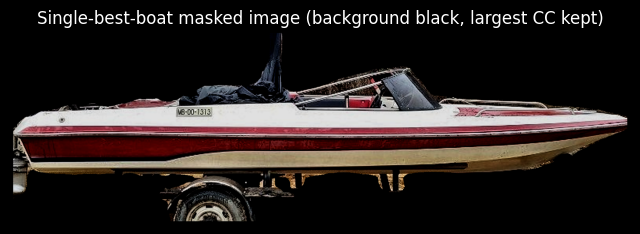

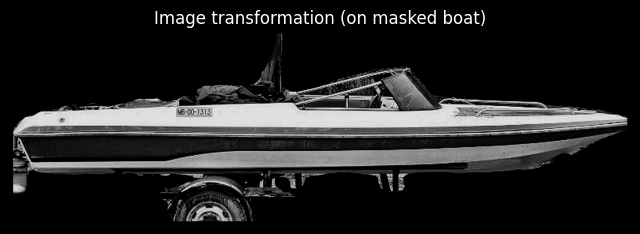

In [28]:
# 2) YOLOv8-seg 로드 및 인퍼런스
try:
    from ultralytics import YOLO
except Exception as e:
    raise ImportError("ultralytics가 설치되어 있지 않습니다. 'pip install ultralytics' 수행 후 다시 실행하세요.") from e

model = YOLO(MODEL_WEIGHTS)
results = model(img_ori, imgsz=640, retina_masks=True)  # retina_masks -> mask at image scale when possible

# 기본: 전체 이미지 사용 (fallback)
img_for_processing = img_ori.copy()
boat_mask_combined = np.zeros((height, width), dtype=np.uint8)
found_boat = False

# 3) 결과에서 boat 클래스 중 confidence 최고 하나 선택
if len(results) > 0:
    r = results[0]
    masks_obj = getattr(r, 'masks', None)
    boxes_obj = getattr(r, 'boxes', None)
    names = getattr(model, 'names', None)

    # try reading mask tensor and boxes info robustly
    mask_data = None
    try:
        if masks_obj is not None:
            mask_data = masks_obj.data.cpu().numpy()  # (N, H, W)
    except Exception:
        try:
            if masks_obj is not None:
                mask_data = np.asarray(masks_obj.data)
        except Exception:
            mask_data = None

    confs = None
    cls_idxs = None
    try:
        if boxes_obj is not None:
            confs = boxes_obj.conf.cpu().numpy()
            cls_idxs = boxes_obj.cls.cpu().numpy().astype(int)
    except Exception:
        try:
            if boxes_obj is not None:
                confs = np.array([float(x) for x in boxes_obj.conf])
                cls_idxs = np.array([int(x) for x in boxes_obj.cls])
        except Exception:
            confs, cls_idxs = None, None

    # collect indices of detections where class == 'boat'
    candidate_indices = []
    if cls_idxs is not None and names is not None:
        for idx, cls_id in enumerate(cls_idxs):
            class_name = names[int(cls_id)] if int(cls_id) in names else str(int(cls_id))
            if class_name.lower() == 'boat':
                candidate_indices.append(idx)

    # choose index with highest confidence among candidates
    chosen_idx = None
    if candidate_indices:
        if confs is not None:
            # choose candidate index with max conf
            best = max(candidate_indices, key=lambda i: confs[i])
            chosen_idx = int(best)
        else:
            chosen_idx = int(candidate_indices[0])

    # build mask from mask_data if available
    if chosen_idx is not None and mask_data is not None:
        try:
            m = mask_data[chosen_idx]  # soft mask in [0,1]
            m_bin = (m > 0.5).astype(np.uint8)
            # resize if needed
            if m_bin.shape[0] != height or m_bin.shape[1] != width:
                m_bin = cv2.resize(m_bin, (width, height), interpolation=cv2.INTER_NEAREST)
                m_bin = (m_bin > 0).astype(np.uint8)
            boat_mask_combined = m_bin
            found_boat = True
        except Exception:
            found_boat = False

    # fallback: if mask_data missing, attempt polygons (masks.xy)
    if not found_boat and masks_obj is not None:
        try:
            polys = masks_obj.xy  # list of polygons per detection (or list of lists)
            if polys is not None and cls_idxs is not None:
                # pick candidate polygons
                candidate_polys = []
                for idx, poly in enumerate(polys):
                    class_name = names[int(cls_idxs[idx])] if names is not None and int(cls_idxs[idx]) in names else ''
                    if class_name.lower() == 'boat':
                        candidate_polys.append((idx, poly))
                if candidate_polys:
                    if confs is not None:
                        best = max(candidate_polys, key=lambda t: confs[t[0]])
                        chosen_poly = best[1]
                    else:
                        chosen_poly = candidate_polys[0][1]
                    # rasterize polygon(s) (poly may be list of rings)
                    mask_tmp = np.zeros((height, width), dtype=np.uint8)
                    if isinstance(chosen_poly, (list, tuple)) and len(chosen_poly) and isinstance(chosen_poly[0], (list, tuple, np.ndarray)):
                        # multiple rings/polys
                        for ring in chosen_poly:
                            pts = np.array([ring], dtype=np.int32)
                            cv2.fillPoly(mask_tmp, pts, 1)
                    else:
                        pts = np.array([chosen_poly], dtype=np.int32)
                        cv2.fillPoly(mask_tmp, pts, 1)
                    boat_mask_combined = mask_tmp
                    found_boat = True
        except Exception:
            pass

# 4) 최종: 선택된 마스크가 있으면 -> largest connected component만 살리고 배경 블랙
if not found_boat:
    print("YOLOv8에서 'boat'를 검출하지 못했거나 마스크가 없음. 전체 이미지 사용 (마스킹 안함).")
    img_for_processing = img_ori.copy()
else:
    # ensure binary 0/1
    final_soft = (boat_mask_combined > 0).astype(np.uint8)

    # connected components: keep the largest (ignore background label 0)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(final_soft, connectivity=8)
    if num_labels <= 1:
        final_mask = final_soft.copy()
    else:
        # areas for labels 1..N-1
        areas = stats[1:, cv2.CC_STAT_AREA]
        max_idx_rel = int(np.argmax(areas))
        max_label = max_idx_rel + 1
        final_mask = (labels == max_label).astype(np.uint8)

        # optional cleanup: closing to fill small holes
        k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, k_close, iterations=1)
        # after closing, ensure again largest CC
        num_labels2, labels2, stats2, _ = cv2.connectedComponentsWithStats(final_mask, connectivity=8)
        if num_labels2 > 1:
            areas2 = stats2[1:, cv2.CC_STAT_AREA]
            max_idx2 = int(np.argmax(areas2))
            max_label2 = max_idx2 + 1
            final_mask = (labels2 == max_label2).astype(np.uint8)

    # create 0/255 uint8 mask
    boat_mask_uint8 = (final_mask * 255).astype(np.uint8)

    # apply mask: background -> black
    img_for_processing = img_ori.copy()
    inv_mask = (boat_mask_uint8 == 0)
    img_for_processing[inv_mask] = (0,0,0)

    # crop to mask bbox (optional, reduces processing area)
    ys, xs = np.where(boat_mask_uint8 > 0)
    if len(xs) > 0 and len(ys) > 0:
        x1, x2 = int(xs.min()), int(xs.max())
        y1, y2 = int(ys.min()), int(ys.max())
        pad = 8
        x1 = max(0, x1-pad); y1 = max(0, y1-pad)
        x2 = min(width, x2+pad); y2 = min(height, y2+pad)
        img_for_processing = img_for_processing[y1:y2, x1:x2]
    else:
        img_for_processing = img_ori.copy()

# show masked image used for further processing
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_for_processing, cv2.COLOR_BGR2RGB))
plt.title('Single-best-boat masked image (background black, largest CC kept)')
plt.axis('off')
plt.show()

gray = cv2.cvtColor(img_for_processing, cv2.COLOR_BGR2GRAY)

# 4) 결과 보여주기 (처리본 한 장씩)
plt.figure(figsize=(8,8))
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.title('Image transformation (on masked boat)')
plt.show()


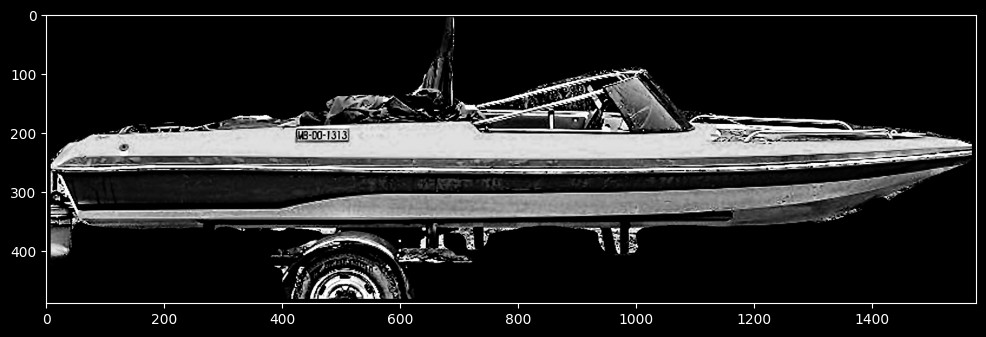

In [119]:
gray_clahe=gray
img_blurred = cv2.bilateralFilter(gray_clahe, d=5, sigmaColor=25, sigmaSpace=25)

structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))

imgTopHat = cv2.morphologyEx(img_blurred, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(img_blurred, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(img_blurred, imgTopHat)
gray_clahe = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

plt.figure(figsize=(12, 10))
plt.imshow(gray_clahe, cmap='gray')

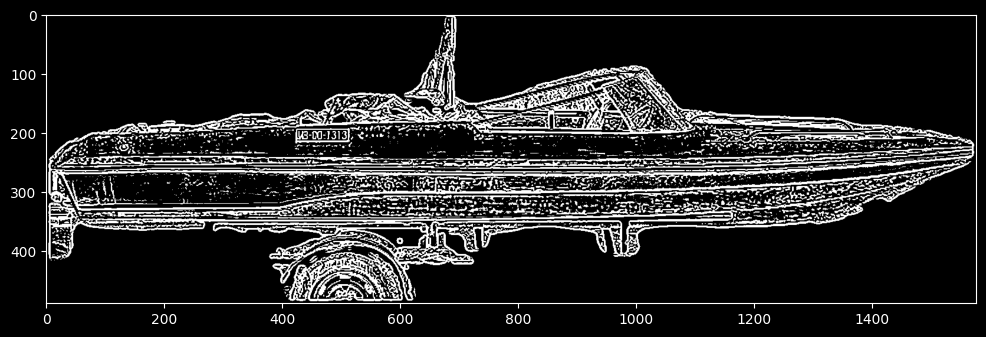

In [120]:
img_thresh = cv2.adaptiveThreshold(
    gray_clahe,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=9,
    C=3
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

# Find Contours

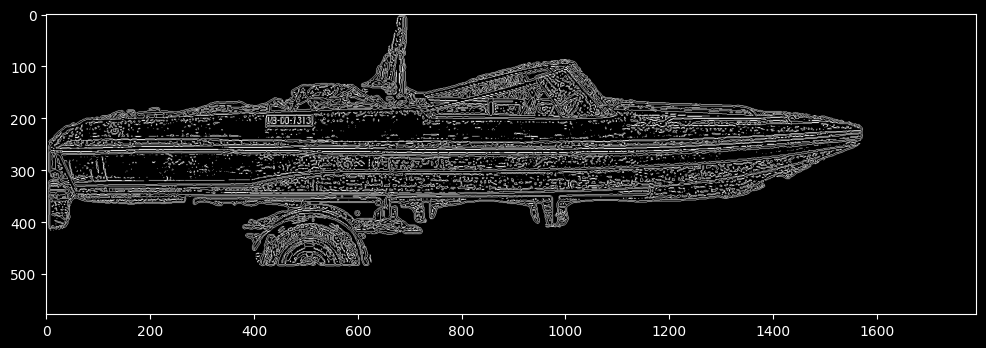

In [121]:
contours,_  = cv2.findContours(
    img_thresh,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

# Prepare Data

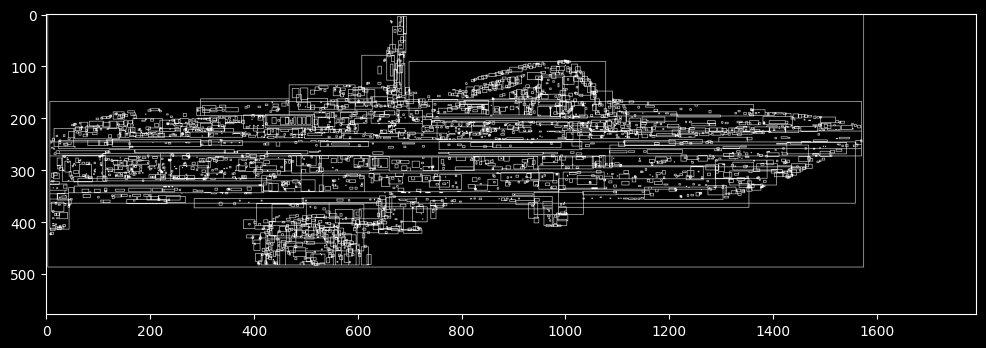

In [111]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=1)

    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# Select Candidates by Char Size

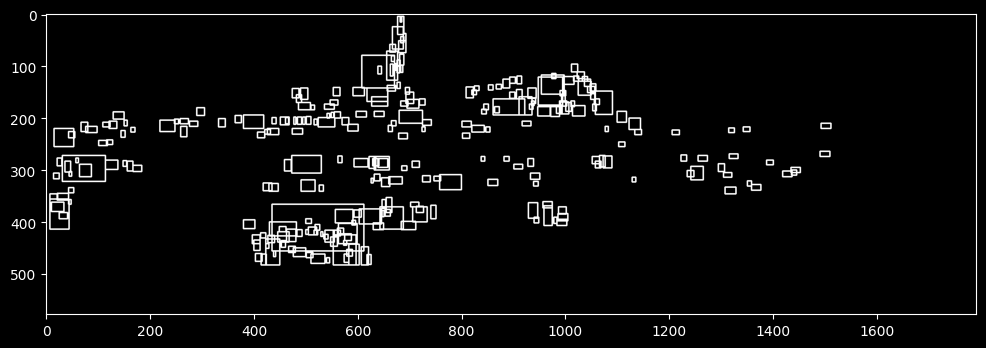

In [112]:
# --- 자동 상대값 설정 (이미지 크기 기반) ---
img_area = height * width
MIN_AREA = max(8, int(img_area * 0.000005))   # 매우 작게 허용 (예: 8 픽셀 이상)
MIN_WIDTH = 1                                  # 최소 너비 1픽셀 허용
MIN_HEIGHT = max(8, int(height * 0.004))       # 최소 높이 작게 허용 (예: 4픽셀)
MIN_RATIO, MAX_RATIO = 0.2, 2.0               # 매우 얇거나 넓은 것도 허용 (후에 병합으로 정리)

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']

    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# Select Candidates by Arrangement of Contours

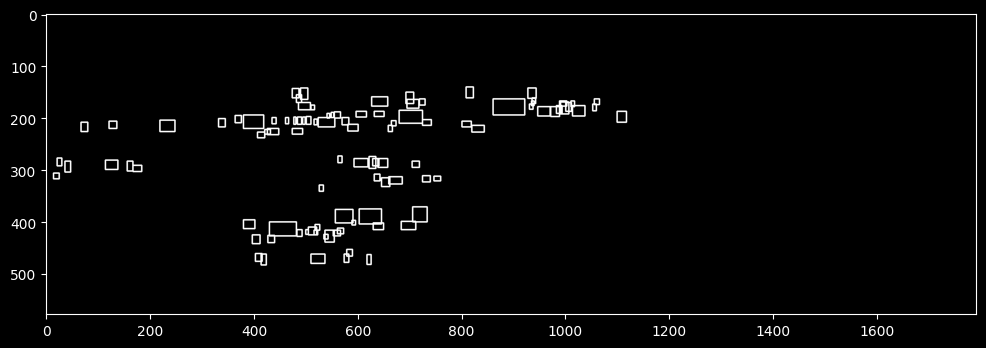

In [113]:
# 관대(유하게) 설정 (원래값보다 느슨하게)
MAX_DIAG_MULTIPLYER = 5   # 원래 5 -> 더 멀리 있는 문자까지 허용
MAX_ANGLE_DIFF = 12       # 원래 12 -> 더 기울어진 라인 허용
MAX_AREA_DIFF = 0.8         # 원래 0.5 -> 면적 차 80%까지 허용
MAX_WIDTH_DIFF =  2        # 원래 0.8 -> 너비 차 더 관대하게
MAX_HEIGHT_DIFF = 0.4       # 원래 0.2 -> 높이 차 더 관대하게
MIN_N_MATCHED = 6           # 원래 3 -> 2개만 있어도 그룹 인정 (짧은 시퀀스 허용)


def find_chars(contour_list):
    matched_result_idx = []

    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)

        # recursive
        recursive_contour_list = find_chars(unmatched_contour)

        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx

result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
#         cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# Rotate Plate Images

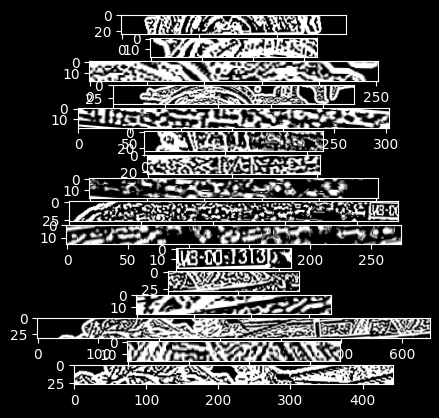

In [114]:
PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2

    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING

    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)

    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) -
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )

    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))

    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)

    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))

    img_cropped = cv2.getRectSubPix(
        img_rotated,
        patchSize=(int(plate_width), int(plate_height)),
        center=(int(plate_cx), int(plate_cy))
    )

    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue

    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })

    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')

# Another Thresholding to Find Chars

TRTRSSFREO
LEA
NN
ZEEE
MSSSAOIC3
2WPABRG
SARHRE
FASA2ONAENEON
PEDSEELEIIENEETEAESBO
IOYE
CRENRCRESP
BISA
EMO
ENSAYO
VALENADARS
ROCESS


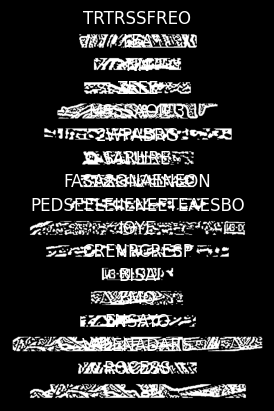

In [115]:
import re
from PIL import Image
import pytesseract # Add pytesseract import here

longest_idx, longest_text = -1, 0
plate_chars = []

# Tesseract 기본 config: 대문자, 숫자, 하이픈만 허용
base_cfg = r'--oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-'

# 후보 psm 순서: 한 줄(line), 단어(word), 단일 텍스트 라인 등
psm_list = ['--psm 7', '--psm 6', '--psm 8']

# O/I 등 혼동 문자 매핑 (숫자처럼 보일 때만 적용)
confusion_map = {'O': '0', 'Q': '0', 'D': '0', 'I': '1', 'L': '1', 'Z': '2', 'S': '5', 'B': '8', 'G': '6'}

for i, plate_img in enumerate(plate_imgs):
    # 그레이 채널 보장
    if plate_img.ndim == 3:
        plate_img = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)

    # 크기 키우고 이진화
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6, interpolation=cv2.INTER_CUBIC)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # 컨투어로 문자 영역을 좁힘 (원래 로직 유지)
    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h
        ratio = w / float(h + 1e-6)
        if area > MIN_AREA and w > MIN_WIDTH and h > MIN_HEIGHT and (MIN_RATIO < ratio < MAX_RATIO):
            plate_min_x = min(plate_min_x, x)
            plate_min_y = min(plate_min_y, y)
            plate_max_x = max(plate_max_x, x + w)
            plate_max_y = max(plate_max_y, y + h)

    # 잘랐는데 값이 이상하면 전체 사용
    if plate_max_x <= plate_min_x or plate_max_y <= plate_min_y:
        img_result = plate_img.copy()
    else:
        img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]

    # 약간 부드럽게 + 재임계화, 테두리 추가 (테두리 색을 흰색(255)으로 변경)
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0,
                                  type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # change value=255 -> value=0 for black border
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10,
                                    borderType=cv2.BORDER_CONSTANT, value=0)

    # OCR 시도: 여러 psm + variant(orig/inv)로 재시도 (lang='eng' 명시)
    recognized = ''
    # create two simple variants: original and inverted (some plates OCR better inverted)
    variants = {
        'orig': img_result,
        'inv' : 255 - img_result
    }

    for psm in psm_list:
        if recognized:
            break
        for vname, vimg in variants.items():
            cfg = base_cfg + ' ' + psm
            pil = Image.fromarray(vimg.astype('uint8'))
            # 명시적으로 영어 모델 사용
            raw = pytesseract.image_to_string(pil, lang='eng', config=cfg)
            # 정리: 대문자화 및 허용 문자만 남김
            cleaned = re.sub(r'[^A-Za-z0-9\-]', '', raw).upper()
            cleaned = re.sub(r'-{2,}', '-', cleaned)  # 연속 하이픈 정리
            if cleaned:
                recognized = cleaned
                break

    # 후처리 휴리스틱: 하이픈으로 섹션 나누어 숫자 섹션은 O->0 등 보정
    if recognized:
        parts = recognized.split('-')
        fixed_parts = []
        for part in parts:
            if not part:
                fixed_parts.append(part)
                continue
            digit_count = sum(c.isdigit() for c in part)
            # 만약 해당 파트가 주로 숫자(절반 이상)라면 혼동 문자 치환
            if digit_count >= (len(part) / 2.0):
                newp = ''.join(confusion_map.get(c, c) for c in part)
            else:
                newp = part
            fixed_parts.append(newp)
        result_chars = '-'.join(fixed_parts)
    else:
        result_chars = ''

    # 최종 안전 필터: 허용 문자만, 연속 하이픈 정리
    result_chars = re.sub(r'[^A-Z0-9\-]', '', result_chars)
    result_chars = re.sub(r'-{2,}', '-', result_chars).strip('-')

    # 숫자 포함 여부 판단
    has_digit = any(ch.isdigit() for ch in result_chars)

    print(result_chars)
    plate_chars.append(result_chars)

    # longest_text 업데이트 버그 수정
    if has_digit and len(result_chars) > longest_text:
        longest_idx = i
        longest_text = len(result_chars)

    # 시각화
    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')
    plt.title(result_chars)
    plt.axis('off')

# Result

FASA2ONAENEON


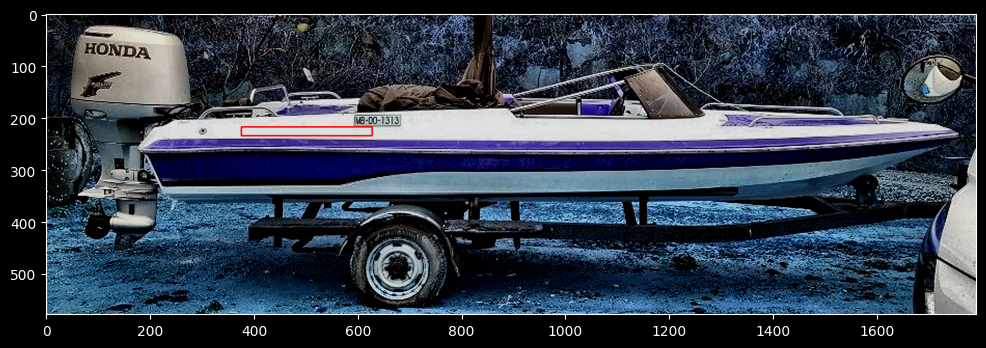

In [116]:
info = plate_infos[longest_idx]
chars = plate_chars[longest_idx]

print(chars)

img_out = img_ori.copy()

cv2.rectangle(img_out, pt1=(info['x'], info['y']), pt2=(info['x']+info['w'], info['y']+info['h']), color=(255,0,0), thickness=2)

cv2.imwrite(chars + '.jpg', img_out)

plt.figure(figsize=(12, 10))
plt.imshow(img_out)